# Residual Analysis of Gaussian Stack Model

In this notebook we will perform multiple runs of the model, and see how the inversion performs when certain input parameters are varied. 

In [238]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import beta, chisquare
from utils import *

## Test Simulation

The function below performs a test simulation. 

Input variables are:

* $n$: The number of samples
* $p$: The assumed number of suspended mass clouds
* $z_{min}$ and $z_{max}$: The heights of the lowest and heighest suspended mass level
* $q_{dist}$: The pdf of the vertical mass distribution in the plume
* $\sigma^2$: The diffusion coefficient as defined in Bonadonna et al (2005), i.e. the variance of a single suspended mass cloud
* $M_{total}$: The total ejected mass
* sample_dev: The variance of the random sampling distribution. Sample mean is taken at the point of highest mass accumulation. 
* $u$: The wind speed
* $v$: The terminal fall velocity


In [346]:
s_sqr = 1e9

# Terminal Fall Velocity
v = -9.4

# Wind Speed
u = 30

In [ ]:
def run_sim(n, p, z_min, z_max, q_dist, s_sqr, tot_mass, sample_dev, scaling_factor, lstsq):
    # Release points in column
    z = np.linspace(z_min, z_max, p)

    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, v) for zk in z]

    #Mass distribution in the plume
    q_mass = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)
    
    q = q_mass*scaling_factor
    
    input_data = np.asarray([z, np.asarray(q_mass), np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Height (z)", 
                                                     "Suspended Mass (q)", 
                                                     "Scaled Mass (q)", 
                                                     "Landing Points (x_bar)"])


    xx = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 51)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-x_range/2, x_range/2, 51)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    for k, zh in enumerate(z):
        # Gaussian dispersal
        dist = f(X, Y, s_sqr, x_bar[k], y_bar=0)
        sus_dist = f(X, Y, s_sqr, 0, y_bar=0)
        dep_mass += dist*q[k]
        sus_mass.append(sus_dist*q[k])
        
    max_point = xx[np.unravel_index(dep_mass.argmax(), dep_mass.shape)[0]]

    samp_mean = [max_point, 0]
    samp_cov = [[sample_dev, 0], [0, s_sqr]]
    samp_x, samp_y = np.random.multivariate_normal(samp_mean, samp_cov, p).T
    
    n = p
    a = np.zeros((n,p))
    for i in range(n):
        for k in range(p):
            a[i,k] = f(samp_x[i], samp_y[i], s_sqr, x_bar[k], 0)
    coefficient_matrix = pd.DataFrame(a)
    det = np.linalg.det(a)
    m = np.matmul(a, q)
    
    sample_data = np.asarray([samp_x, samp_y, m]).T
    sample_table = pd.DataFrame(sample_data, columns=["X", "Y", "Deposit Mass"])
    
    if (lstsq):
        lst_q = np.linalg.lstsq(a, m)
        q_inv = lst_q[0]
    else:
        q_inv = np.linalg.solve(a, m)
    q_inv_mass = q_inv/scaling_factor
    res = q_mass - q_inv_mass
    res_perc = (res/(q_mass+1e-100))*100
    inversion_data = np.asarray([np.asarray(z), np.asarray(q_mass), np.asarray(q), q_inv, q_inv_mass, res, res_perc]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass", "Scaled Mass",  "Scaled Inverted Mass", "Inverted Mass", "Residual", "Residual Percentage"])
    return inversion_table, sample_table, coefficient_matrix, input_table, det

## Test 1: Number of column levels

In this test, we vary the number of assumed levels in the plume, $p$.

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1666.666667        1.949318e+07     1.949318e+07   
2          3333.333333        7.338608e+07     7.338608e+07   
3          5000.000000        1.547988e+08     1.547988e+08   
4          6666.666667        2.568513e+08     2.568513e+08   
5          8333.333333        3.726637e+08     3.726637e+08   
6         10000.000000        4.953560e+08     4.953560e+08   
7         11666.666667        6.180484e+08     6.180484e+08   
8         13333.333333        7.338608e+08     7.338608e+08   
9         15000.000000        8.359133e+08     8.359133e+08   
10        16666.666667        9.173260e+08     9.173260e+08   
11        18333.333333        9.712189e+08     9.712189e+08   
12        20000.000000        9.907121e+08     9.907121e+08   
13        21666.666667        9.689256e+08     9.689256e+08   
14        23333.333333        8.989795e+08     8.989795e+08   
15        25000.000000        7.739938e+08     7.739938e+08   
16        26666.666667        5.870886e+08     5.870886e+08   
17        28333.333333        3.313840e+08     3.313840e+08   
18        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5319.148936  
2             10638.297872  
3             15957.446809  
4             21276.595745  
5             26595.744681  
6             31914.893617  
7             37234.042553  
8             42553.191489  
9             47872.340426  
10            53191.489362  
11            58510.638298  
12            63829.787234  
13            69148.936170  
14            74468.085106  
15            79787.234043  
16            85106.382979  
17            90425.531915  
18            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1578.947368        1.662050e+07     1.662050e+07   
2          3157.894737        6.278855e+07     6.278855e+07   
3          4736.842105        1.329640e+08     1.329640e+08   
4          6315.789474        2.216066e+08     2.216066e+08   
5          7894.736842        3.231764e+08     3.231764e+08   
6          9473.684211        4.321330e+08     4.321330e+08   
7         11052.631579        5.429363e+08     5.429363e+08   
8         12631.578947        6.500462e+08     6.500462e+08   
9         14210.526316        7.479224e+08     7.479224e+08   
10        15789.473684        8.310249e+08     8.310249e+08   
11        17368.421053        8.938135e+08     8.938135e+08   
12        18947.368421        9.307479e+08     9.307479e+08   
13        20526.315789        9.362881e+08     9.362881e+08   
14        22105.263158        9.048938e+08     9.048938e+08   
15        23684.210526        8.310249e+08     8.310249e+08   
16        25263.157895        7.091413e+08     7.091413e+08   
17        26842.105263        5.337027e+08     5.337027e+08   
18        28421.052632        2.991690e+08     2.991690e+08   
19        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5039.193729  
2             10078.387458  
3             15117.581187  
4             20156.774916  
5             25195.968645  
6             30235.162374  
7             35274.356103  
8             40313.549832  
9             45352.743561  
10            50391.937290  
11            55431.131019  
12            60470.324748  
13            65509.518477  
14            70548.712206  
15            75587.905935  
16            80627.099664  
17            85666.293393  
18            90705.487122  
19            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1500.0        1.428571e+07     1.428571e+07   
2               3000.0        5.413534e+07     5.413534e+07   
3               4500.0        1.150376e+08     1.150376e+08   
4               6000.0        1.924812e+08     1.924812e+08   
5               7500.0        2.819549e+08     2.819549e+08   
6               9000.0        3.789474e+08     3.789474e+08   
7              10500.0        4.789474e+08     4.789474e+08   
8              12000.0        5.774436e+08     5.774436e+08   
9              13500.0        6.699248e+08     6.699248e+08   
10             15000.0        7.518797e+08     7.518797e+08   
11             16500.0        8.187970e+08     8.187970e+08   
12             18000.0        8.661654e+08     8.661654e+08   
13             19500.0        8.894737e+08     8.894737e+08   
14             21000.0        8.842105e+08     8.842105e+08   
15             22500.0        8.458647e+08     8.458647e+08   
16             24000.0        7.699248e+08     7.699248e+08   
17             25500.0        6.518797e+08     6.518797e+08   
18             27000.0        4.872180e+08     4.872180e+08   
19             28500.0        2.714286e+08     2.714286e+08   
20             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              4787.234043  
2              9574.468085  
3             14361.702128  
4             19148.936170  
5             23936.170213  
6             28723.404255  
7             33510.638298  
8             38297.872340  
9             43085.106383  
10            47872.340426  
11            52659.574468  
12            57446.808511  
13            62234.042553  
14            67021.276596  
15            71808.510638  
16            76595.744681  
17            81382.978723  
18            86170.212766  
19            90957.446809  
20            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1428.571429        1.236858e+07     1.236858e+07   
2          2857.142857        4.700062e+07     4.700062e+07   
3          4285.714286        1.001855e+08     1.001855e+08   
4          5714.285714        1.682127e+08     1.682127e+08   
5          7142.857143        2.473717e+08     2.473717e+08   
6          8571.428571        3.339518e+08     3.339518e+08   
7         10000.000000        4.242424e+08     4.242424e+08   
8         11428.571429        5.145331e+08     5.145331e+08   
9         12857.142857        6.011132e+08     6.011132e+08   
10        14285.714286        6.802721e+08     6.802721e+08   
11        15714.285714        7.482993e+08     7.482993e+08   
12        17142.857143        8.014842e+08     8.014842e+08   
13        18571.428571        8.361163e+08     8.361163e+08   
14        20000.000000        8.484848e+08     8.484848e+08   
15        21428.571429        8.348794e+08     8.348794e+08   
16        22857.142857        7.915894e+08     7.915894e+08   
17        24285.714286        7.149041e+08     7.149041e+08   
18        25714.285714        6.011132e+08     6.011132e+08   
19        27142.857143        4.465059e+08     4.465059e+08   
20        28571.428571        2.473717e+08     2.473717e+08   
21        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              4559.270517  
2              9118.541033  
3             13677.811550  
4             18237.082067  
5             22796.352584  
6             27355.623100  
7             31914.893617  
8             36474.164134  
9             41033.434650  
10            45592.705167  
11            50151.975684  
12            54711.246201  
13            59270.516717  
14            63829.787234  
15            68389.057751  
16            72948.328267  
17            77507.598784  
18            82066.869301  
19            86626.139818  
20            91185.410334  
21            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1363.636364        1.077973e+07     1.077973e+07   
2          2727.272727        4.106565e+07     4.106565e+07   
3          4090.909091        8.777783e+07     8.777783e+07   
4          5454.545455        1.478364e+08     1.478364e+08   
5          6818.181818        2.181613e+08     2.181613e+08   
6          8181.818182        2.956727e+08     2.956727e+08   
7          9545.454545        3.772907e+08     3.772907e+08   
8         10909.090909        4.599353e+08     4.599353e+08   
9         12272.727273        5.405267e+08     5.405267e+08   
10        13636.363636        6.159848e+08     6.159848e+08   
11        15000.000000        6.832298e+08     6.832298e+08   
12        16363.636364        7.391818e+08     7.391818e+08   
13        17727.272727        7.807607e+08     7.807607e+08   
14        19090.909091        8.048868e+08     8.048868e+08   
15        20454.545455        8.084801e+08     8.084801e+08   
16        21818.181818        7.884606e+08     7.884606e+08   
17        23181.818182        7.417484e+08     7.417484e+08   
18        24545.454545        6.652636e+08     6.652636e+08   
19        25909.090909        5.559263e+08     5.559263e+08   
20        27272.727273        4.106565e+08     4.106565e+08   
21        28636.363636        2.263744e+08     2.263744e+08   
22        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              4352.030948  
2              8704.061896  
3             13056.092843  
4             17408.123791  
5             21760.154739  
6             26112.185687  
7             30464.216634  
8             34816.247582  
9             39168.278530  
10            43520.309478  
11            47872.340426  
12            52224.371373  
13            56576.402321  
14            60928.433269  
15            65280.464217  
16            69632.495164  
17            73984.526112  
18            78336.557060  
19            82688.588008  
20            87040.618956  
21            91392.649903  
22            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1304.347826        9.451796e+06     9.451796e+06   
2          2608.695652        3.608868e+07     3.608868e+07   
3          3913.043478        7.733288e+07     7.733288e+07   
4          5217.391304        1.306066e+08     1.306066e+08   
5          6521.739130        1.933322e+08     1.933322e+08   
6          7826.086957        2.629318e+08     2.629318e+08   
7          9130.434783        3.368276e+08     3.368276e+08   
8         10434.782609        4.124420e+08     4.124420e+08   
9         11739.130435        4.871971e+08     4.871971e+08   
10        13043.478261        5.585152e+08     5.585152e+08   
11        14347.826087        6.238185e+08     6.238185e+08   
12        15652.173913        6.805293e+08     6.805293e+08   
13        16956.521739        7.260698e+08     7.260698e+08   
14        18260.869565        7.578622e+08     7.578622e+08   
15        19565.217391        7.733288e+08     7.733288e+08   
16        20869.565217        7.698917e+08     7.698917e+08   
17        22173.913043        7.449734e+08     7.449734e+08   
18        23478.260870        6.959959e+08     6.959959e+08   
19        24782.608696        6.203815e+08     6.203815e+08   
20        26086.956522        5.155525e+08     5.155525e+08   
21        27391.304348        3.789311e+08     3.789311e+08   
22        28695.652174        2.079395e+08     2.079395e+08   
23        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              4162.812211  
2              8325.624422  
3             12488.436633  
4             16651.248844  
5             20814.061055  
6             24976.873265  
7             29139.685476  
8             33302.497687  
9             37465.309898  
10            41628.122109  
11            45790.934320  
12            49953.746531  
13            54116.558742  
14            58279.370953  
15            62442.183164  
16            66604.995375  
17            70767.807586  
18            74930.619796  
19            79093.432007  
20            83256.244218  
21            87419.056429  
22            91581.868640  
23            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1250.0        8.333333e+06     8.333333e+06   
2               2500.0        3.188406e+07     3.188406e+07   
3               3750.0        6.847826e+07     6.847826e+07   
4               5000.0        1.159420e+08     1.159420e+08   
5               6250.0        1.721014e+08     1.721014e+08   
6               7500.0        2.347826e+08     2.347826e+08   
7               8750.0        3.018116e+08     3.018116e+08   
8              10000.0        3.710145e+08     3.710145e+08   
9              11250.0        4.402174e+08     4.402174e+08   
10             12500.0        5.072464e+08     5.072464e+08   
11             13750.0        5.699275e+08     5.699275e+08   
12             15000.0        6.260870e+08     6.260870e+08   
13             16250.0        6.735507e+08     6.735507e+08   
14             17500.0        7.101449e+08     7.101449e+08   
15             18750.0        7.336957e+08     7.336957e+08   
16             20000.0        7.420290e+08     7.420290e+08   
17             21250.0        7.329710e+08     7.329710e+08   
18             22500.0        7.043478e+08     7.043478e+08   
19             23750.0        6.539855e+08     6.539855e+08   
20             25000.0        5.797101e+08     5.797101e+08   
21             26250.0        4.793478e+08     4.793478e+08   
22             27500.0        3.507246e+08     3.507246e+08   
23             28750.0        1.916667e+08     1.916667e+08   
24             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              3989.361702  
2              7978.723404  
3             11968.085106  
4             15957.446809  
5             19946.808511  
6             23936.170213  
7             27925.531915  
8             31914.893617  
9             35904.255319  
10            39893.617021  
11            43882.978723  
12            47872.340426  
13            51861.702128  
14            55851.063830  
15            59840.425532  
16            63829.787234  
17            67819.148936  
18            71808.510638  
19            75797.872340  
20            79787.234043  
21            83776.595745  
22            87765.957447  
23            91755.319149  
24            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1200.0        7.384615e+06     7.384615e+06   
2               2400.0        2.830769e+07     2.830769e+07   
3               3600.0        6.092308e+07     6.092308e+07   
4               4800.0        1.033846e+08     1.033846e+08   
5               6000.0        1.538462e+08     1.538462e+08   
6               7200.0        2.104615e+08     2.104615e+08   
7               8400.0        2.713846e+08     2.713846e+08   
8               9600.0        3.347692e+08     3.347692e+08   
9              10800.0        3.987692e+08     3.987692e+08   
10             12000.0        4.615385e+08     4.615385e+08   
11             13200.0        5.212308e+08     5.212308e+08   
12             14400.0        5.760000e+08     5.760000e+08   
13             15600.0        6.240000e+08     6.240000e+08   
14             16800.0        6.633846e+08     6.633846e+08   
15             18000.0        6.923077e+08     6.923077e+08   
16             19200.0        7.089231e+08     7.089231e+08   
17             20400.0        7.113846e+08     7.113846e+08   
18             21600.0        6.978462e+08     6.978462e+08   
19             22800.0        6.664615e+08     6.664615e+08   
20             24000.0        6.153846e+08     6.153846e+08   
21             25200.0        5.427692e+08     5.427692e+08   
22             26400.0        4.467692e+08     4.467692e+08   
23             27600.0        3.255385e+08     3.255385e+08   
24             28800.0        1.772308e+08     1.772308e+08   
25             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              3829.787234  
2              7659.574468  
3             11489.361702  
4             15319.148936  
5             19148.936170  
6             22978.723404  
7             26808.510638  
8             30638.297872  
9             34468.085106  
10            38297.872340  
11            42127.659574  
12            45957.446809  
13            49787.234043  
14            53617.021277  
15            57446.808511  
16            61276.595745  
17            65106.382979  
18            68936.170213  
19            72765.957447  
20            76595.744681  
21            80425.531915  
22            84255.319149  
23            88085.106383  
24            91914.893617  
25            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1153.846154        6.574622e+06     6.574622e+06   
2          2307.692308        2.524655e+07     2.524655e+07   
3          3461.538462        5.443787e+07     5.443787e+07   
4          4615.384615        9.257068e+07     9.257068e+07   
5          5769.230769        1.380671e+08     1.380671e+08   
6          6923.076923        1.893491e+08     1.893491e+08   
7          8076.923077        2.448389e+08     2.448389e+08   
8          9230.769231        3.029586e+08     3.029586e+08   
9         10384.615385        3.621302e+08     3.621302e+08   
10        11538.461538        4.207758e+08     4.207758e+08   
11        12692.307692        4.773176e+08     4.773176e+08   
12        13846.153846        5.301775e+08     5.301775e+08   
13        15000.000000        5.777778e+08     5.777778e+08   
14        16153.846154        6.185404e+08     6.185404e+08   
15        17307.692308        6.508876e+08     6.508876e+08   
16        18461.538462        6.732413e+08     6.732413e+08   
17        19615.384615        6.840237e+08     6.840237e+08   
18        20769.230769        6.816568e+08     6.816568e+08   
19        21923.076923        6.645628e+08     6.645628e+08   
20        23076.923077        6.311637e+08     6.311637e+08   
21        24230.769231        5.798817e+08     5.798817e+08   
22        25384.615385        5.091387e+08     5.091387e+08   
23        26538.461538        4.173570e+08     4.173570e+08   
24        27692.307692        3.029586e+08     3.029586e+08   
25        28846.153846        1.643655e+08     1.643655e+08   
26        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              3682.487725  
2              7364.975450  
3             11047.463175  
4             14729.950900  
5             18412.438625  
6             22094.926350  
7             25777.414075  
8             29459.901800  
9             33142.389525  
10            36824.877250  
11            40507.364975  
12            44189.852700  
13            47872.340426  
14            51554.828151  
15            55237.315876  
16            58919.803601  
17            62602.291326  
18            66284.779051  
19            69967.266776  
20            73649.754501  
21            77332.242226  
22            81014.729951  
23            84697.217676  
24            88379.705401  
25            92062.193126  
26            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1111.111111        5.878895e+06     5.878895e+06   
2          2222.222222        2.261113e+07     2.261113e+07   
3          3333.333333        4.884005e+07     4.884005e+07   
4          4444.444444        8.320897e+07     8.320897e+07   
5          5555.555556        1.243612e+08     1.243612e+08   
6          6666.666667        1.709402e+08     1.709402e+08   
7          7777.777778        2.215891e+08     2.215891e+08   
8          8888.888889        2.749514e+08     2.749514e+08   
9         10000.000000        3.296703e+08     3.296703e+08   
10        11111.111111        3.843893e+08     3.843893e+08   
11        12222.222222        4.377515e+08     4.377515e+08   
12        13333.333333        4.884005e+08     4.884005e+08   
13        14444.444444        5.349794e+08     5.349794e+08   
14        15555.555556        5.761317e+08     5.761317e+08   
15        16666.666667        6.105006e+08     6.105006e+08   
16        17777.777778        6.367295e+08     6.367295e+08   
17        18888.888889        6.534618e+08     6.534618e+08   
18        20000.000000        6.593407e+08     6.593407e+08   
19        21111.111111        6.530095e+08     6.530095e+08   
20        22222.222222        6.331117e+08     6.331117e+08   
21        23333.333333        5.982906e+08     5.982906e+08   
22        24444.444444        5.471894e+08     5.471894e+08   
23        25555.555556        4.784516e+08     4.784516e+08   
24        26666.666667        3.907204e+08     3.907204e+08   
25        27777.777778        2.826392e+08     2.826392e+08   
26        28888.888889        1.528513e+08     1.528513e+08   
27        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              3546.099291  
2              7092.198582  
3             10638.297872  
4             14184.397163  
5             17730.496454  
6             21276.595745  
7             24822.695035  
8             28368.794326  
9             31914.893617  
10            35460.992908  
11            39007.092199  
12            42553.191489  
13            46099.290780  
14            49645.390071  
15            53191.489362  
16            56737.588652  
17            60283.687943  
18            63829.787234  
19            67375.886525  
20            70921.985816  
21            74468.085106  
22            78014.184397  
23            81560.283688  
24            85106.382979  
25            88652.482270  
26            92198.581560  
27            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1071.428571        5.277973e+06     5.277973e+06   
2          2142.857143        2.032997e+07     2.032997e+07   
3          3214.285714        4.398311e+07     4.398311e+07   
4          4285.714286        7.506451e+07     7.506451e+07   
5          5357.142857        1.124013e+08     1.124013e+08   
6          6428.571429        1.548205e+08     1.548205e+08   
7          7500.000000        2.011494e+08     2.011494e+08   
8          8571.428571        2.502150e+08     2.502150e+08   
9          9642.857143        3.008445e+08     3.008445e+08   
10        10714.285714        3.518649e+08     3.518649e+08   
11        11785.714286        4.021034e+08     4.021034e+08   
12        12857.142857        4.503871e+08     4.503871e+08   
13        13928.571429        4.955430e+08     4.955430e+08   
14        15000.000000        5.363985e+08     5.363985e+08   
15        16071.428571        5.717804e+08     5.717804e+08   
16        17142.857143        6.005161e+08     6.005161e+08   
17        18214.285714        6.214325e+08     6.214325e+08   
18        19285.714286        6.333568e+08     6.333568e+08   
19        20357.142857        6.351161e+08     6.351161e+08   
20        21428.571429        6.255376e+08     6.255376e+08   
21        22500.000000        6.034483e+08     6.034483e+08   
22        23571.428571        5.676753e+08     5.676753e+08   
23        24642.857143        5.170459e+08     5.170459e+08   
24        25714.285714        4.503871e+08     4.503871e+08   
25        26785.714286        3.665259e+08     3.665259e+08   
26        27857.142857        2.642896e+08     2.642896e+08   
27        28928.571429        1.425053e+08     1.425053e+08   
28        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              3419.452888  
2              6838.905775  
3             10258.358663  
4             13677.811550  
5             17097.264438  
6             20516.717325  
7             23936.170213  
8             27355.623100  
9             30775.075988  
10            34194.528875  
11            37613.981763  
12            41033.434650  
13            44452.887538  
14            47872.340426  
15            51291.793313  
16            54711.246201  
17            58130.699088  
18            61550.151976  
19            64969.604863  
20            68389.057751  
21            71808.510638  
22            75227.963526  
23            78647.416413  
24            82066.869301  
25            85486.322188  
26            88905.775076  
27            92325.227964  
28            95744.680851

<IPython.core.display.Javascript object>


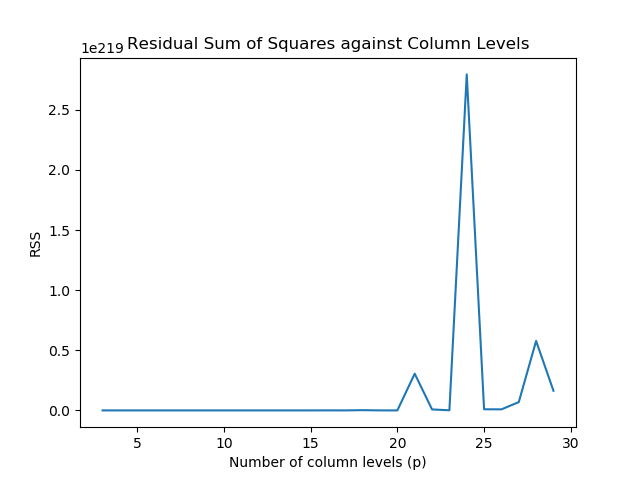

<IPython.core.display.Javascript object>


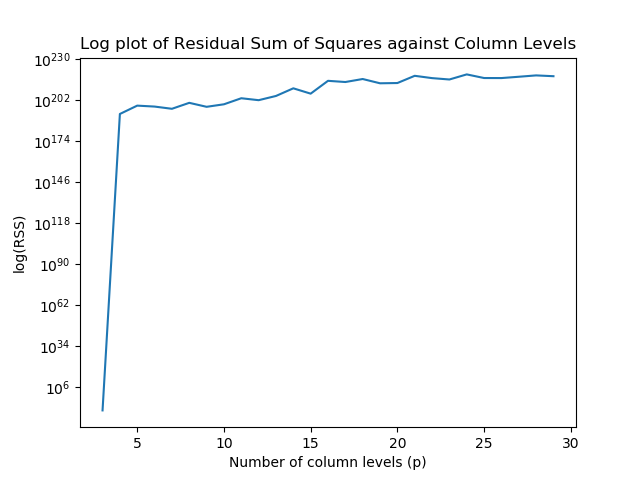

Text(0,0.5,'log(RSS)')

In [349]:
p_list = range(3,30)

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(p_list)))

for i, p in enumerate(p_list):
    inversion_table, sample_table, coefficient_matrix, input_table, det = run_sim(p, p, z_min, z_max, 
                                                                             q_dist, s_sqr, tot_mass, 
                                                                             sig, 1, False)
    res_sqr = inversion_table["Residual Percentage"].values**2
    rss = sum(res_sqr)
    resses[i] = rss

plt.figure()
plt.plot(p_list, resses+1e-10)
plt.title("Residual Sum of Squares against Column Levels")
plt.xlabel("Number of column levels (p)")
plt.ylabel("RSS")

plt.figure()
plt.semilogy(p_list, resses+1e-10)
plt.title("Log plot of Residual Sum of Squares against Column Levels")
plt.xlabel("Number of column levels (p)")
plt.ylabel("log(RSS)")
# plt.colorbar()

## Test 2: Sample Spread

In this test, the spread of the sampling distribution is varied. 

This value is varied as a factor of the diffusion coefficient, within the range $[0.01 \times \sigma^2, 5 \times \sigma^2]$

<IPython.core.display.Javascript object>


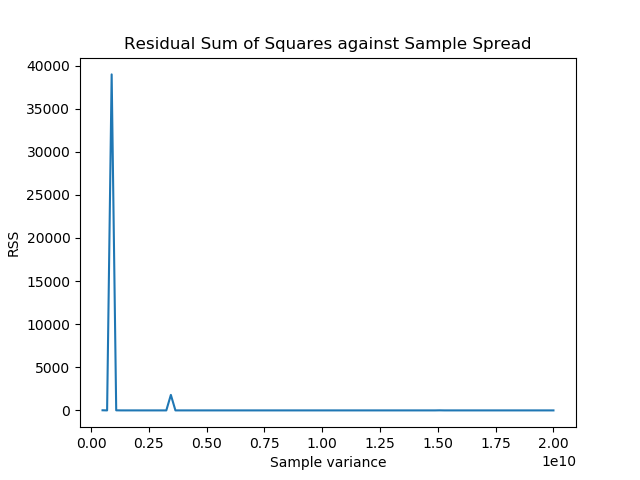

<IPython.core.display.Javascript object>


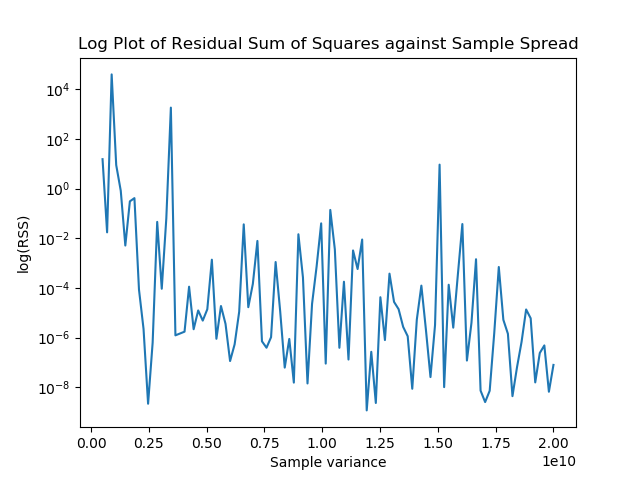

Text(0,0.5,'log(RSS)')

In [322]:
p=8
scales = np.linspace(0.5, 20, 100)
sig_list = scales*s_sqr
# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(sig_list)))

for i, sig in enumerate(sig_list):
    inversion_table, sample_table, coefficient_matrix, input_table, det = run_sim(p, p, z_min, z_max, 
                                                                                  q_dist, s_sqr, tot_mass, 
                                                                                  sig, 1, False)
    res_sqr = inversion_table["Residual"].values**2
    rss = sum(res_sqr)/p
    resses[i] = rss

plt.figure()
plt.plot(sig_list, resses+1e-10)
plt.title("Residual Sum of Squares against Sample Spread")
plt.xlabel("Sample variance")
plt.ylabel("RSS")

plt.figure()
plt.semilogy(sig_list, resses+1e-10)
plt.title("Log Plot of Residual Sum of Squares against Sample Spread")
plt.xlabel("Sample variance")
plt.ylabel("log(RSS)")

# plt.colorbar()

## Test 3: Varying both $p$ and the sample spread

Here, both variations above are combined.

In [ ]:
p_list = list(range(3,30))
scales = np.linspace(0.5, 20,50)
sig_list = scales*s_sqr

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(p_list), len(sig_list)))

for i, p in enumerate(p_list):
    for j, sig in enumerate(sig_list):
        inversion_table, sample_table, coefficient_matrix, input_table, det = run_sim(p, p, z_min, 
                                                                                      z_max, q_dist, 
                                                                                      s_sqr, tot_mass,
                                                                                      sig, 1, True)
        res_sqr = inversion_table["Residual"].values**2
        rss = sum(res_sqr)
        resses[i,j] = rss

plt.figure()
plt.imshow(resses+1e-10, cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("RSS")
locs = list(range(len(sig_list)))
locs = locs[::5]
labs = ['%.1E'%s for s in sig_list[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()

plt.figure()
plt.imshow(np.log(resses+1e-10), cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("log(RSS)")
locs = list(range(len(scales)))
locs = locs[::5]
labs = ['%.1f x sigma'%s for s in scales[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              6000.0        8.000000e+08     8.000000e+08   
2             12000.0        2.400000e+09     2.400000e+09   
3             18000.0        3.600000e+09     3.600000e+09   
4             24000.0        3.200000e+09     3.200000e+09   
5             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            19148.936170  
2            38297.872340  
3            57446.808511  
4            76595.744681  
5            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              5000.0        4.761905e+08     4.761905e+08   
2             10000.0        1.523810e+09     1.523810e+09   
3             15000.0        2.571429e+09     2.571429e+09   
4             20000.0        3.047619e+09     3.047619e+09   
5             25000.0        2.380952e+09     2.380952e+09   
6             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            15957.446809  
2            31914.893617  
3            47872.340426  
4            63829.787234  
5            79787.234043  
6            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         4285.714286        3.061224e+08     3.061224e+08   
2         8571.428571        1.020408e+09     1.020408e+09   
3        12857.142857        1.836735e+09     1.836735e+09   
4        17142.857143        2.448980e+09     2.448980e+09   
5        21428.571429        2.551020e+09     2.551020e+09   
6        25714.285714        1.836735e+09     1.836735e+09   
7        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            13677.811550  
2            27355.623100  
3            41033.434650  
4            54711.246201  
5            68389.057751  
6            82066.869301  
7            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              3750.0        2.083333e+08     2.083333e+08   
2              7500.0        7.142857e+08     7.142857e+08   
3             11250.0        1.339286e+09     1.339286e+09   
4             15000.0        1.904762e+09     1.904762e+09   
5             18750.0        2.232143e+09     2.232143e+09   
6             22500.0        2.142857e+09     2.142857e+09   
7             26250.0        1.458333e+09     1.458333e+09   
8             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            11968.085106  
2            23936.170213  
3            35904.255319  
4            47872.340426  
5            59840.425532  
6            71808.510638  
7            83776.595745  
8            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0            0.000000        0.000000e+00     0.000000e+00   
1         3333.333333        1.481481e+08     1.481481e+08   
2         6666.666667        5.185185e+08     5.185185e+08   
3        10000.000000        1.000000e+09     1.000000e+09   
4        13333.333333        1.481481e+09     1.481481e+09   
5        16666.666667        1.851852e+09     1.851852e+09   
6        20000.000000        2.000000e+09     2.000000e+09   
7        23333.333333        1.814815e+09     1.814815e+09   
8        26666.666667        1.185185e+09     1.185185e+09   
9        30000.000000        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            10638.297872  
2            21276.595745  
3            31914.893617  
4            42553.191489  
5            53191.489362  
6            63829.787234  
7            74468.085106  
8            85106.382979  
9            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               3000.0        1.090909e+08     1.090909e+08   
2               6000.0        3.878788e+08     3.878788e+08   
3               9000.0        7.636364e+08     7.636364e+08   
4              12000.0        1.163636e+09     1.163636e+09   
5              15000.0        1.515152e+09     1.515152e+09   
6              18000.0        1.745455e+09     1.745455e+09   
7              21000.0        1.781818e+09     1.781818e+09   
8              24000.0        1.551515e+09     1.551515e+09   
9              27000.0        9.818182e+08     9.818182e+08   
10             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              9574.468085  
2             19148.936170  
3             28723.404255  
4             38297.872340  
5             47872.340426  
6             57446.808511  
7             67021.276596  
8             76595.744681  
9             86170.212766  
10            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2727.272727        8.264463e+07     8.264463e+07   
2          5454.545455        2.975207e+08     2.975207e+08   
3          8181.818182        5.950413e+08     5.950413e+08   
4         10909.090909        9.256198e+08     9.256198e+08   
5         13636.363636        1.239669e+09     1.239669e+09   
6         16363.636364        1.487603e+09     1.487603e+09   
7         19090.909091        1.619835e+09     1.619835e+09   
8         21818.181818        1.586777e+09     1.586777e+09   
9         24545.454545        1.338843e+09     1.338843e+09   
10        27272.727273        8.264463e+08     8.264463e+08   
11        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              8704.061896  
2             17408.123791  
3             26112.185687  
4             34816.247582  
5             43520.309478  
6             52224.371373  
7             60928.433269  
8             69632.495164  
9             78336.557060  
10            87040.618956  
11            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2500.0        6.410256e+07     6.410256e+07   
2               5000.0        2.331002e+08     2.331002e+08   
3               7500.0        4.720280e+08     4.720280e+08   
4              10000.0        7.459207e+08     7.459207e+08   
5              12500.0        1.019814e+09     1.019814e+09   
6              15000.0        1.258741e+09     1.258741e+09   
7              17500.0        1.427739e+09     1.427739e+09   
8              20000.0        1.491841e+09     1.491841e+09   
9              22500.0        1.416084e+09     1.416084e+09   
10             25000.0        1.165501e+09     1.165501e+09   
11             27500.0        7.051282e+08     7.051282e+08   
12             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7978.723404  
2             15957.446809  
3             23936.170213  
4             31914.893617  
5             39893.617021  
6             47872.340426  
7             55851.063830  
8             63829.787234  
9             71808.510638  
10            79787.234043  
11            87765.957447  
12            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2307.692308        5.071851e+07     5.071851e+07   
2          4615.384615        1.859679e+08     1.859679e+08   
3          6923.076923        3.803888e+08     3.803888e+08   
4          9230.769231        6.086221e+08     6.086221e+08   
5         11538.461538        8.453085e+08     8.453085e+08   
6         13846.153846        1.065089e+09     1.065089e+09   
7         16153.846154        1.242604e+09     1.242604e+09   
8         18461.538462        1.352494e+09     1.352494e+09   
9         20769.230769        1.369400e+09     1.369400e+09   
10        23076.923077        1.267963e+09     1.267963e+09   
11        25384.615385        1.022823e+09     1.022823e+09   
12        27692.307692        6.086221e+08     6.086221e+08   
13        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              7364.975450  
2             14729.950900  
3             22094.926350  
4             29459.901800  
5             36824.877250  
6             44189.852700  
7             51554.828151  
8             58919.803601  
9             66284.779051  
10            73649.754501  
11            81014.729951  
12            88379.705401  
13            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          2142.857143        4.081633e+07     4.081633e+07   
2          4285.714286        1.507064e+08     1.507064e+08   
3          6428.571429        3.108320e+08     3.108320e+08   
4          8571.428571        5.023548e+08     5.023548e+08   
5         10714.285714        7.064364e+08     7.064364e+08   
6         12857.142857        9.042386e+08     9.042386e+08   
7         15000.000000        1.076923e+09     1.076923e+09   
8         17142.857143        1.205651e+09     1.205651e+09   
9         19285.714286        1.271586e+09     1.271586e+09   
10        21428.571429        1.255887e+09     1.255887e+09   
11        23571.428571        1.139717e+09     1.139717e+09   
12        25714.285714        9.042386e+08     9.042386e+08   
13        27857.142857        5.306122e+08     5.306122e+08   
14        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6838.905775  
2             13677.811550  
3             20516.717325  
4             27355.623100  
5             34194.528875  
6             41033.434650  
7             47872.340426  
8             54711.246201  
9             61550.151976  
10            68389.057751  
11            75227.963526  
12            82066.869301  
13            88905.775076  
14            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               2000.0        3.333333e+07     3.333333e+07   
2               4000.0        1.238095e+08     1.238095e+08   
3               6000.0        2.571429e+08     2.571429e+08   
4               8000.0        4.190476e+08     4.190476e+08   
5              10000.0        5.952381e+08     5.952381e+08   
6              12000.0        7.714286e+08     7.714286e+08   
7              14000.0        9.333333e+08     9.333333e+08   
8              16000.0        1.066667e+09     1.066667e+09   
9              18000.0        1.157143e+09     1.157143e+09   
10             20000.0        1.190476e+09     1.190476e+09   
11             22000.0        1.152381e+09     1.152381e+09   
12             24000.0        1.028571e+09     1.028571e+09   
13             26000.0        8.047619e+08     8.047619e+08   
14             28000.0        4.666667e+08     4.666667e+08   
15             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              6382.978723  
2             12765.957447  
3             19148.936170  
4             25531.914894  
5             31914.893617  
6             38297.872340  
7             44680.851064  
8             51063.829787  
9             57446.808511  
10            63829.787234  
11            70212.765957  
12            76595.744681  
13            82978.723404  
14            89361.702128  
15            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                  0.0        0.000000e+00     0.000000e+00   
1               1875.0        2.757353e+07     2.757353e+07   
2               3750.0        1.029412e+08     1.029412e+08   
3               5625.0        2.150735e+08     2.150735e+08   
4               7500.0        3.529412e+08     3.529412e+08   
5               9375.0        5.055147e+08     5.055147e+08   
6              11250.0        6.617647e+08     6.617647e+08   
7              13125.0        8.106618e+08     8.106618e+08   
8              15000.0        9.411765e+08     9.411765e+08   
9              16875.0        1.042279e+09     1.042279e+09   
10             18750.0        1.102941e+09     1.102941e+09   
11             20625.0        1.112132e+09     1.112132e+09   
12             22500.0        1.058824e+09     1.058824e+09   
13             24375.0        9.319853e+08     9.319853e+08   
14             26250.0        7.205882e+08     7.205882e+08   
15             28125.0        4.136029e+08     4.136029e+08   
16             30000.0        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5984.042553  
2             11968.085106  
3             17952.127660  
4             23936.170213  
5             29920.212766  
6             35904.255319  
7             41888.297872  
8             47872.340426  
9             53856.382979  
10            59840.425532  
11            65824.468085  
12            71808.510638  
13            77792.553191  
14            83776.595745  
15            89760.638298  
16            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0             0.000000        0.000000e+00     0.000000e+00   
1          1764.705882        2.306805e+07     2.306805e+07   
2          3529.411765        8.650519e+07     8.650519e+07   
3          5294.117647        1.816609e+08     1.816609e+08   
4          7058.823529        2.998847e+08     2.998847e+08   
5          8823.529412        4.325260e+08     4.325260e+08   
6         10588.235294        5.709343e+08     5.709343e+08   
7         12352.941176        7.064591e+08     7.064591e+08   
8         14117.647059        8.304498e+08     8.304498e+08   
9         15882.352941        9.342561e+08     9.342561e+08   
10        17647.058824        1.009227e+09     1.009227e+09   
11        19411.764706        1.046713e+09     1.046713e+09   
12        21176.470588        1.038062e+09     1.038062e+09   
13        22941.176471        9.746251e+08     9.746251e+08   
14        24705.882353        8.477509e+08     8.477509e+08   
15        26470.588235        6.487889e+08     6.487889e+08   
16        28235.294118        3.690888e+08     3.690888e+08   
17        30000.000000        0.000000e+00     0.000000e+00   

    Landing Points (x_bar)  
0                 0.000000  
1              5632.040050  
2             11264.080100  
3             16896.120150  
4             22528.160200  
5             28160.200250  
6             33792.240300  
7             39424.280350  
8             45056.320401  
9             50688.360451  
10            56320.400501  
11            61952.440551  
12            67584.480601  
13            73216.520651  
14            78848.560701  
15            84480.600751  
16            90112.640801  
17            95744.680851

## Test 4: Dividing everything by a billion

In [350]:
p_list = list(range(3,30))
scales = np.logspace(0, 0,50)
sig = 5*s_sqr

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(p_list), len(sig_list)))

for i, p in enumerate(p_list):
    for j, sc in enumerate(scales):
#         print(sc)
        inversion_table, sample_table, coefficient_matrix, input_table, det = run_sim(p, p, z_min, 
                                                                                      z_max, q_dist, 
                                                                                      s_sqr, tot_mass,
                                                                                      3, 1, False)
        res_sqr = inversion_table["Residual"].values**2
        rss = sum(res_sqr)
        resses[i,j] = rss

plt.figure()
plt.imshow(resses+1e-10, cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("RSS")
locs = list(range(len(sig_list)))
locs = locs[::5]
labs = ['%.1E'%s for s in sig_list[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()

plt.figure()
plt.imshow(np.log(resses+1e-10), cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("log(RSS)")
locs = list(range(len(sig_list)))
locs = locs[::5]
labs = ['%.1E'%s for s in sig_list[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()

plt.figure()
plt.plot(z)

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             15000.0        1.000000e+10     1.000000e+10   
2             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            47872.340426  
2            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1             10000.0        3.333333e+09     3.333333e+09   
2             20000.0        6.666667e+09     6.666667e+09   
3             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            31914.893617  
2            63829.787234  
3            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

Release Height (z)  Suspended Mass (q)  Scaled Mass (q)  \
0                 0.0        0.000000e+00     0.000000e+00   
1              7500.0        1.500000e+09     1.500000e+09   
2             15000.0        4.000000e+09     4.000000e+09   
3             22500.0        4.500000e+09     4.500000e+09   
4             30000.0        0.000000e+00     0.000000e+00   

   Landing Points (x_bar)  
0                0.000000  
1            23936.170213  
2            47872.340426  
3            71808.510638  
4            95744.680851

LinAlgError: Singular matrix